# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)
## Importing Custom Functions
import sys,os
import joblib
# sys.path.append(os.path.abspath("../"))
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

# Functions

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax
    

# Data

In [4]:
## Load the joblib file stored in the models folder
fname = "Models/best-models.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [5]:
X_train = loaded['X_train']
y_train = loaded['y_train']
X_test = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
lin_model = loaded['LinearRegression']
reg_model= loaded['RandomForestRegressor']
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,157.2946,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,82.3250,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,120.9098,2002,NaN,Tier 2,Supermarket Type1


In [6]:
evaluate_regression(lin_model,X_train,y_train, X_test, y_test)

C:\Users\caill\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Item_Fat_Content
- Outlet_Location_Type
- Outlet_Size
- Outlet_Type
Feature names seen at fit time, yet now missing:
- Item_Fat_Content_Regular
- Outlet_Location_Type_Tier 2
- Outlet_Location_Type_Tier 3
- Outlet_Size_MISSING
- Outlet_Size_Medium
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low Fat'

In [7]:
## Get feature names from already-fit preprocessor

feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.350,0.029565,256.4646,2009.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7510,15.250,0.000000,179.7660,2009.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,12.350,0.158716,157.2946,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,7.975,0.014628,82.3250,2004.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4810,19.350,0.016645,120.9098,2002.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [8]:
## evaluating the linear regression
evaluate_regression(lin_model, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,848.04,"1,140.58"
Test,0.57,804.05,"1,091.01"


In [9]:
## evaluating the random forest
evaluate_regression(reg_model,X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,301.63,432.12
Test,0.55,777.46,"1,114.78"


# Random Regression Permutation Importance

In [10]:
from sklearn.inspection import permutation_importance

In [11]:
r = permutation_importance(reg_model, X_test_df, y_test,n_repeats =5, random_state=SEED)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [12]:
permutation_importances = pd.Series(r['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

Item_MRP                         0.728897
Outlet_Type_Supermarket Type3    0.426840
Outlet_Type_Supermarket Type1    0.407432
Outlet_Establishment_Year        0.020540
Outlet_Size_Medium               0.006648
Item_Visibility                  0.002989
Outlet_Size_Small                0.002328
Outlet_Type_Supermarket Type2    0.000721
Outlet_Size_MISSING             -0.000414
Outlet_Location_Type_Tier 3     -0.000919
Outlet_Location_Type_Tier 2     -0.001358
Item_Fat_Content_Regular        -0.006305
Item_Weight                     -0.012983
Name: permutation importance, dtype: float64

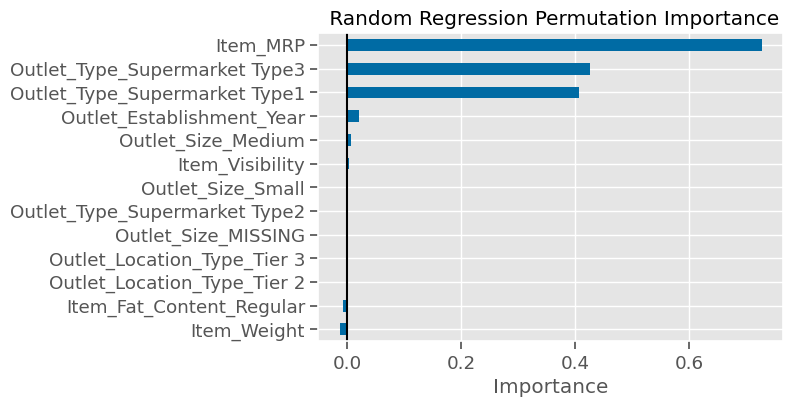

<AxesSubplot: title={'center': ' Random Regression Permutation Importance'}, xlabel='Importance'>

In [29]:
plot_importances(permutation_importances, sort_values=True, top_n=None, figsize=(6,4),
                     title=" Random Regression Permutation Importance", xlabel='Importance')

# LinearRegression Permutation Importance

In [14]:
l = permutation_importance(lin_model, X_test_df, y_test,n_repeats =5, random_state=SEED)
l.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [15]:
perm_importances_linreg = pd.Series(l['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
perm_importances_linreg = perm_importances_linreg.sort_values(ascending=False)
perm_importances_linreg

Item_MRP                         0.641628
Outlet_Type_Supermarket Type3    0.633832
Outlet_Type_Supermarket Type1    0.584400
Outlet_Type_Supermarket Type2    0.129286
Outlet_Location_Type_Tier 2      0.005632
Outlet_Size_Medium               0.002124
Outlet_Location_Type_Tier 3      0.000562
Outlet_Size_Small                0.000306
Outlet_Size_MISSING              0.000176
Item_Weight                     -0.000022
Outlet_Establishment_Year       -0.000079
Item_Visibility                 -0.000086
Item_Fat_Content_Regular        -0.000245
Name: permutation importance, dtype: float64

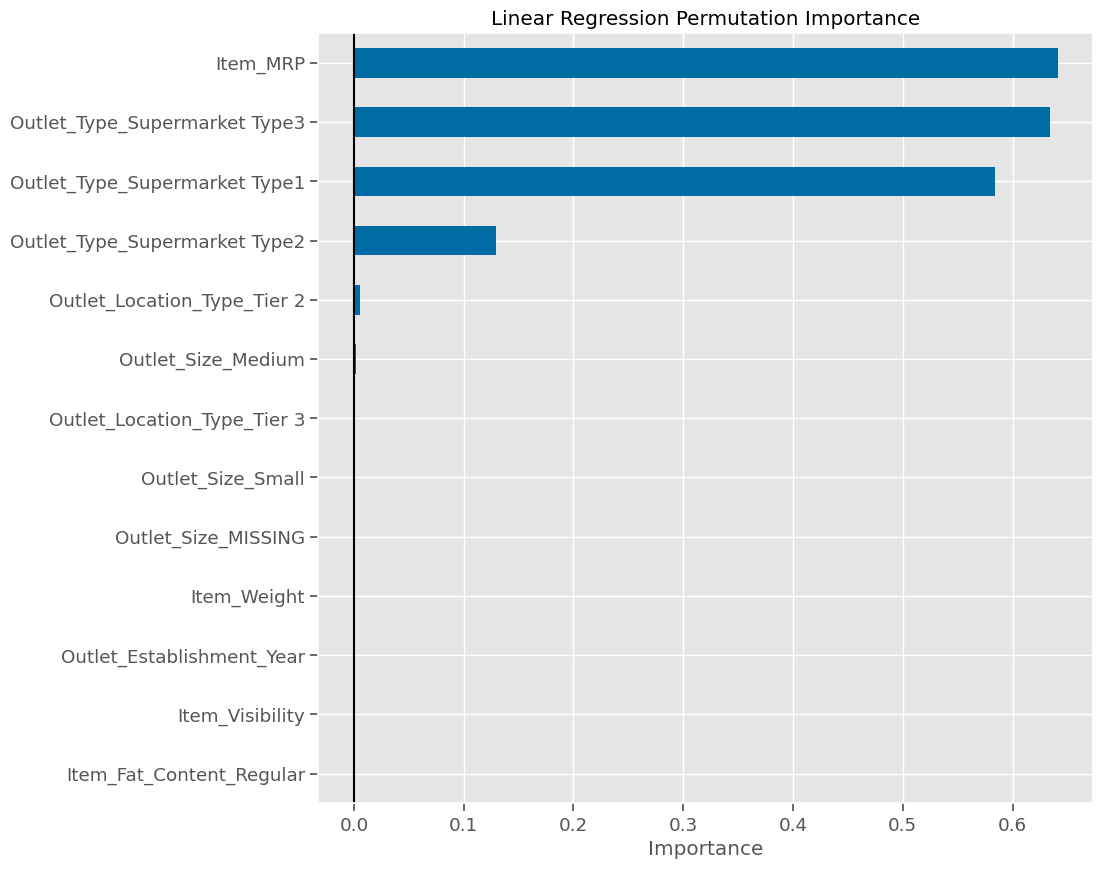

<AxesSubplot: title={'center': 'Linear Regression Permutation Importance'}, xlabel='Importance'>

In [16]:
plot_importances(perm_importances_linreg, sort_values=True, top_n=None, figsize=(10,10),
                     title="Linear Regression Permutation Importance", xlabel='Importance')

![Linear_no_item_type](https://github.com/CaillahR/Importances-and-Coefficients/assets/121994185/44b11a27-3fcc-4e31-a16b-6b72be4fbb6f)

- The Permutation Importance Feature now shows that the 3 most important features for our lin_reg model is also the same most important features as our Random Regression model. However they are not the same for our original model. Outlet_Type_Supermarket Type 3, Type 1, and Type 2 are still in the top 3 but not the others.

# SHAP

In [17]:
# Import and init shap
import shap
shap.initjs()

In [18]:
X_shap = shap.sample(X_train_df,nsamples=500,random_state=SEED)
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
3888,15.85,0.110653,36.9506,2007.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2497,15.10,0.087407,221.8456,1997.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7723,17.50,0.015592,184.8266,2002.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8117,10.80,0.049820,243.2144,2002.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7475,15.00,0.044999,140.4838,2002.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [19]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

3888     759.0120
2497     663.1368
7723    2766.3990
8117    1225.0720
7475    1685.8056
          ...    
3467     506.0080
2322    2888.2404
3435    5069.4012
6561    1030.6584
7431    3691.1952
Name: Item_Outlet_Sales, Length: 500, dtype: float64

In [20]:
rf_explainer = shap.Explainer(reg_model)

## Get shap values from the explainer
rf_shap_values = rf_explainer(X_shap)

In [21]:
rf_shap_values.shape

(500, 13)

In [22]:
rf_shap_values[0]

.values =
array([ 1.87322624e+01, -1.03394965e+01, -1.67649316e+03,  4.97988617e+01,
        4.70572317e+00, -4.27581985e+00, -2.79941231e+01,  4.11302968e+00,
       -6.57094491e+00, -3.82297985e-01,  2.03544326e+02, -1.80140488e+01,
       -9.89751795e+01])

.base_values =
array([2209.98093003])

.data =
array([1.58500000e+01, 1.10653377e-01, 3.69506000e+01, 2.00700000e+03,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [23]:
## Create an explainer for the lin_reg
linreg_explainer = shap.Explainer(lin_model, X_shap) #Leave out X_shap in lecture

## get shap values for linreg
linreg_shap_values = linreg_explainer(X_shap)
linreg_shap_values.shape

(500, 13)

In [24]:
linreg_shap_values[0]

.values =
array([   -4.66322934,   -23.46540375, -1654.92440267,    -7.62115084,
          43.8444726 ,   -67.09266939,   -55.25590186,    -6.10068584,
          99.82696062,   -44.49912111,   660.81601447,  -214.89181815,
        -405.55311223])

.base_values =
2336.0058814417616

.data =
array([1.58500000e+01, 1.10653377e-01, 3.69506000e+01, 2.00700000e+03,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

Text(0.5, 1.0, 'Random Forest SHAP Summary')

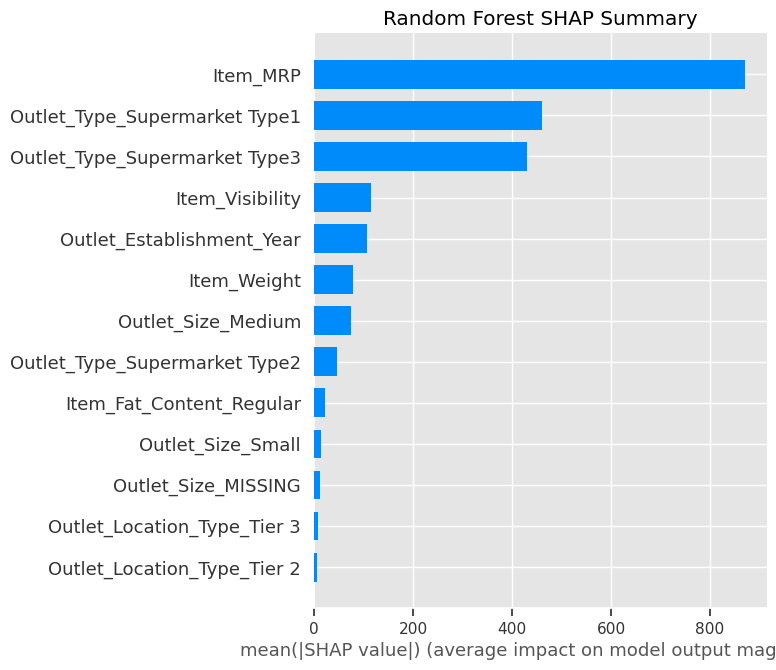

In [25]:
## creating a summary plot (bar version)
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar',
                 show=False)

plt.title('Random Forest SHAP Summary')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Random Forest SHAP Summary')

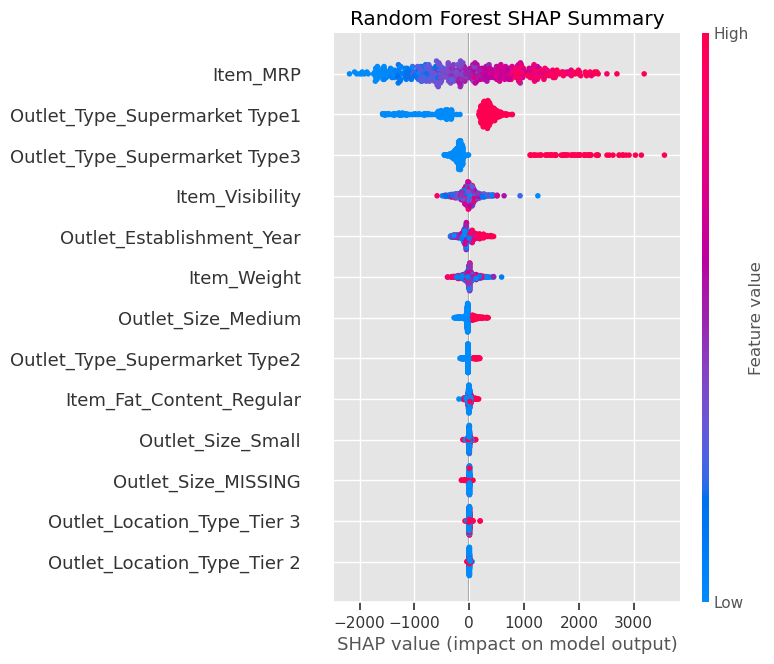

In [26]:
## creating a summary plot (bar version)
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='dot',
                 show=False)

plt.title('Random Forest SHAP Summary')

- 

Text(0.5, 1.0, 'Linear Regression SHAP Summary')

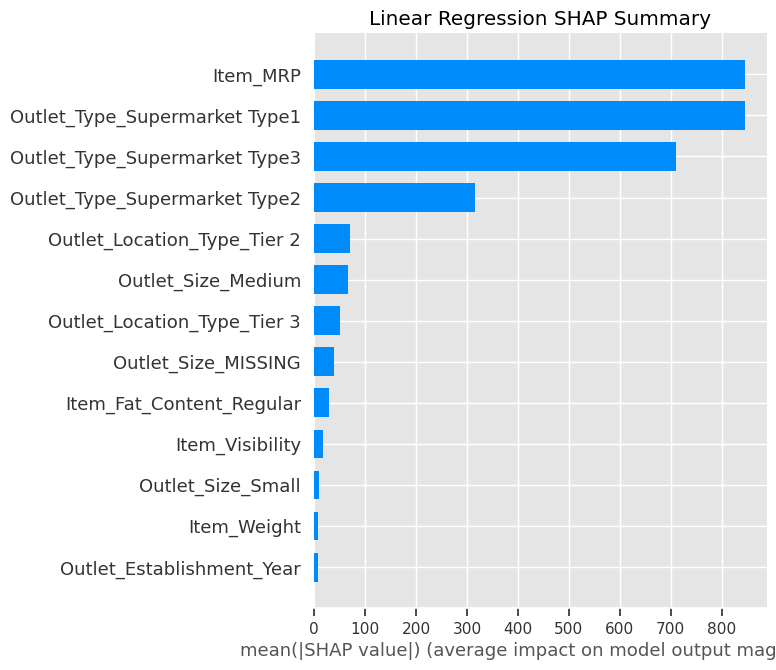

In [27]:
## creating a summary plot for Linear Regression (bar version)
shap.summary_plot(linreg_shap_values, features = X_shap, plot_type='bar',
                 show=False)

plt.title('Linear Regression SHAP Summary')

Text(0.5, 1.0, 'Linear Regression SHAP Summary')

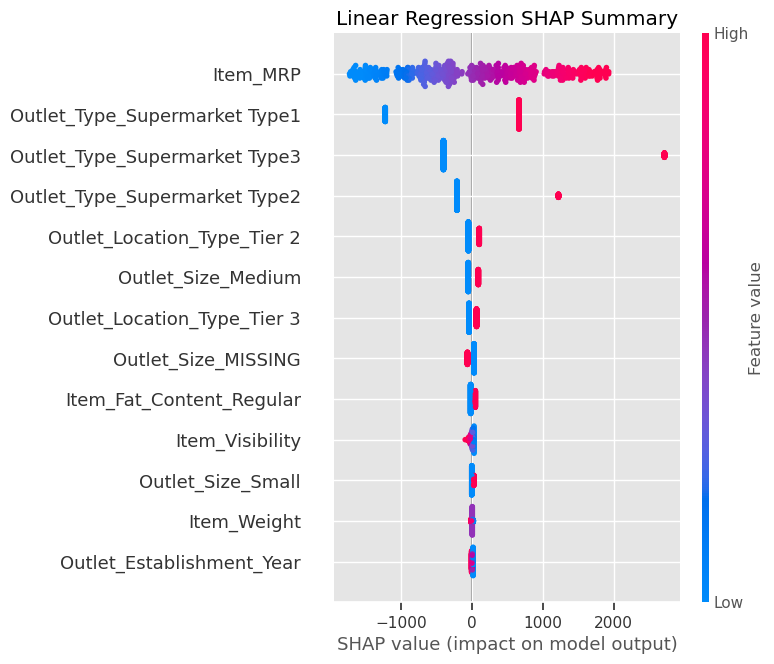

In [28]:
## creating a summary plot for Linear Regression (dot version)
shap.summary_plot(linreg_shap_values, features = X_shap, plot_type='dot',
                 show=False)

plt.title('Linear Regression SHAP Summary')

- 